# Modeling
Data is separated on a candidate-basis to observe polls prior to and before a candidate suspends their campaign.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import numpy as np
import pandas as pd
import os
import math

import stats

## Read File Written in 02-DataCleaning

In [2]:
candidates = pd.read_csv('candidates.csv', index_col='name')

## Read File Written in 03-Modeling

In [3]:
polls = pd.read_csv('bootPolls.csv')

Convert date from string to datetime.

In [4]:
polls.date = pd.Series(pd.DatetimeIndex(polls.date))
polls.index = polls.date
del polls['date']

candidates.date = pd.to_datetime(candidates.date)

stats.Equals100(polls)

## Data Modeling Functions Defintions

### Before Campaign Suspension

Function to get average polling for a single active candidate before a candidate drops out.

In [5]:
def getBeforeAverage(pollGroup, dropout, cand):
    """Returns average polling for a single candidate in the week prior to another candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator. Also used to as denominator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        tot += pollGroup[cand][count]
        count += 1
        iterDate = pollGroup.index[count]

    return tot/count

Function to create list of average polling for all other candidates before a candidate drops out.

In [6]:
def BeforeAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week prior to another
       candidate dropping out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:    # for each candidate
        averages.append(getBeforeAverage(pollGroup, dropout, c))
        
    return averages

### After Campaign Suspension

Function to retrieve difference in days since date of suspension/dropout.

In [7]:
def dateDiff(dropout, iterDate):
    """Returns difference in days between date iterator and the date a candidate dropped out of the race.
    
    Parameters
    ----------
    dropout : str
        The name of the candidate that dropped out.
    iterDate : str
        The name of the candidate whose average polling is being calculated.
    """
    return (iterDate - candidates['date'][dropout]).days

Function to get weighted average polling for a single active candidate after a candidate drops out. Weight is determined by days after campaign suspension; the further away from the date of suspension, the more weight the polling data holds.

In [8]:
def getAfterAverage(pollGroup, dropout, cand):
    """Returns average polling for a candidate in the week after another candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    cand : str
        The name of the candidate whose average polling is being calculated.
    """
    
    tot = 0                             # used to as numerator in calculating the mean
    count = 0                           # regular iterator
    dateCount = 0                       # used to as denomiator in calculating the mean
    iterDate = pollGroup.index[count]   # used to check where date is relative to the date of suspension
    
    # Get the date iterator to the dropout date
    while candidates['date'][dropout] - iterDate >= datetime.timedelta(days=0):
        count += 1
        iterDate = pollGroup.index[count]
    
    # Iterates through poll grouping conducted in the week after a candidate dropped out of the race
    while count < len(pollGroup.index):
        iterDate = pollGroup.index[count]
        diff = dateDiff(dropout, iterDate)
        candCount = pollGroup[cand][count]
        
        if math.isnan(candCount) == False:    # only uses numbers
            tot += candCount * diff           # gives weight to polls conducted further away from the date of dropping
            dateCount += diff
        count += 1
        
    if dateCount == 0:    # can't divide by zero, so just return 0 if no polls conducted after date of dropping
        return float('nan')
    else:
        return tot/dateCount

Function to get weighted average polling for all other candidtates after a candidate drops out.

In [9]:
def AfterAverages(pollGroup, dropout):
    """Returns a list of average polling for all active candidate in the week after another
       candidate drops out of the race.
    
    Parameters
    ----------
    pollGroup : DataFrame
        A snippet of the main DataFrame used sliced to only include polls take a week prior to and a week 
        after the dropout suspends their campaign.
    dropout : str
        The name of the candidate that dropped out.
    """
    
    averages = []
    for c in pollGroup.columns:
        averages.append(getAfterAverage(pollGroup, dropout, c))
    return averages

## Data Modeling Functions Apllications

Create a list of dictionaries holding the name of each candidate that suspended their campaign and the DataFrames of polling data from a week before to a week after that candidate suspended their campaign.

In [10]:
pollList = []

pollIndex = [c for c in candidates.index if candidates.dropped[c] == True]
for p in pollIndex:
    pollList.append({'name': p, 'poll': stats.BiWeekPolling(polls, candidates, p)})

Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week prior to a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week before the candidate in the row dropped out.

In [11]:
WeekBeforeDrop = []

for p in range(len(pollList)):
    WeekBeforeDrop.append(BeforeAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingBeforeDrop = pd.DataFrame(WeekBeforeDrop, columns=polls.columns, index=pollIndex)
PollingBeforeDrop.index.names = ['name']
stats.Equals100(PollingBeforeDrop)
PollingBeforeDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,38.276356,19.521200,6.121322,4.954322,7.956667,NaN,NaN,NaN,NaN,NaN,13.066144,NaN,10.103989
Carson,41.183074,18.038500,7.575870,NaN,7.946481,NaN,NaN,NaN,NaN,NaN,16.259611,NaN,8.996463
Christie,35.758093,20.541815,4.385074,4.327389,7.459259,2.473130,2.026296,0.023333,NaN,NaN,14.967556,NaN,8.038056
Fiorina,35.758093,20.541815,4.385074,4.327389,7.459259,2.473130,2.026296,0.023333,NaN,NaN,14.967556,NaN,8.038056
Gilmore,38.685648,19.653519,4.193889,5.331019,8.527407,NaN,NaN,0.019444,NaN,NaN,12.698426,NaN,10.890648
Huckabee,38.281878,17.889956,4.706367,4.396089,7.009778,1.915422,1.520222,0.155667,1.730667,2.632067,11.288289,0.763278,7.710322
Paul,39.245708,18.125056,4.947806,4.159819,6.730833,2.374750,1.591250,0.271250,NaN,2.601167,11.714569,0.650833,7.586958
Rubio,43.593056,22.287593,10.292222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.273056,NaN,12.554074
Santorum,39.245708,18.125056,4.947806,4.159819,6.730833,2.374750,1.591250,0.271250,NaN,2.601167,11.714569,0.650833,7.586958


Create a DataFrame indexed by the candidates that dropped out of the race during the primaries. Each column holds other candidates' average polling numbers in the week after a candidate's campaign suspension.

Each cell contains the polling for a candidate in the column the week after the candidate in the row dropped out.

In [12]:
WeekAfterDrop = []

for p in range(len(pollList)):
    WeekAfterDrop.append(AfterAverages(pollList[p]['poll'], pollList[p]['name']))
    
PollingAfterDrop = pd.DataFrame(WeekAfterDrop, columns=polls.columns, index=pollIndex)
PollingAfterDrop.index.names = ['name']
stats.Equals100(PollingAfterDrop)
PollingAfterDrop

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
name,,,,,,,,,,,,,
Bush,37.419211,19.621886,8.586922,NaN,7.349972,NaN,NaN,NaN,NaN,NaN,14.953164,NaN,12.068844
Carson,44.140356,22.032830,10.426230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.704348,NaN,11.696237
Christie,37.739415,19.300271,7.336343,4.437340,7.869179,NaN,NaN,0.011667,NaN,NaN,13.280548,NaN,10.025237
Fiorina,37.739415,19.300271,7.336343,4.437340,7.869179,NaN,NaN,0.011667,NaN,NaN,13.280548,NaN,10.025237
Gilmore,37.486171,19.394762,7.470675,4.343735,7.926627,NaN,NaN,NaN,NaN,NaN,13.357024,NaN,10.021007
Huckabee,35.937045,19.295455,4.546010,3.936641,7.045101,2.569520,1.861869,0.081818,NaN,2.695,15.087626,0.315556,6.628359
Paul,38.811125,19.726583,4.338903,5.481056,8.565556,2.462824,2.113657,0.019417,NaN,NaN,12.535194,NaN,5.945685
Rubio,41.844845,25.981526,13.971349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.202280
Santorum,38.811125,19.726583,4.338903,5.481056,8.565556,2.462824,2.113657,0.019417,NaN,NaN,12.535194,NaN,5.945685


## Testing
Confirm DataFrame snippets are working as expected. Test on Jeb Bush.

Display date of drop.

In [13]:
candidates['date']['Bush']

Timestamp('2016-02-16 00:00:00')

Confirm data is saved properly after being pushed to a list of dictionaries.

In [14]:
BushPolls1 = polls[(polls.index > candidates['date']['Bush'] - datetime.timedelta(days=7)) \
     & (polls.index < candidates['date']['Bush'] + datetime.timedelta(days=9))]
BushPoll2 = pollList[1]['poll']
assert all(BushPolls1) == all(BushPoll2)

Display polling for candidates a week before to a week after Jeb Bush dropped.

In [15]:
BushPolls1

,Trump,Cruz,Kasich,Bush,Carson,Christie,Fiorina,Gilmore,Huckabee,Paul,Rubio,Santorum,Undecided
date,,,,,,,,,,,,,
2016-02-10,36.344778,22.075778,3.820389,5.648167,9.309444,2.427056,2.355556,0.028333,NaN,NaN,13.221333,NaN,4.769167
2016-02-11,42.348611,17.959444,4.883333,6.343056,8.851667,NaN,NaN,0.011667,NaN,NaN,10.370278,NaN,9.231944
2016-02-14,38.306944,18.856667,7.036389,3.703333,7.388333,NaN,NaN,NaN,NaN,NaN,12.925556,NaN,11.782778
2016-02-15,38.020222,19.239500,7.592667,4.621278,5.545000,NaN,NaN,NaN,NaN,NaN,15.621444,NaN,9.359889
2016-02-16,36.361222,19.474611,7.273833,4.455778,8.688889,NaN,NaN,NaN,NaN,NaN,13.192111,NaN,10.553556
2016-02-17,37.737389,19.639278,7.728667,NaN,8.961111,NaN,NaN,NaN,NaN,NaN,12.302889,NaN,13.630667
2016-02-21,37.131389,19.181667,7.517222,NaN,7.405000,NaN,NaN,NaN,NaN,NaN,14.248611,NaN,14.516111
2016-02-22,37.229722,18.213611,10.567500,NaN,7.171111,NaN,NaN,NaN,NaN,NaN,17.585556,NaN,9.232500
2016-02-24,37.701444,20.951056,7.877333,NaN,7.248333,NaN,NaN,NaN,NaN,NaN,13.750500,NaN,12.471333


Confirm polling data sums up to 100 for each poll

In [16]:
sum(BushPolls1.loc['2016-02-22'].dropna())

100.0

In [17]:
assert sum(BushPolls1.loc['2016-02-10'].dropna()) == 100
assert sum(BushPolls1.loc['2016-02-22'].dropna()) == 100

Confirm polling before drop is accurate.

In [18]:
BushBeforeAvgs1 = BeforeAverages(BushPolls1, 'Bush')
BushBeforeAvgs2 = PollingBeforeDrop.loc['Bush']
assert all(BushBeforeAvgs1) == all(list(BushBeforeAvgs2))
assert sum(BushBeforeAvgs2.dropna()) == 100

Display candidates' average polling data in the week before Jeb Bush suspended his campaign.

In [19]:
print(BushBeforeAvgs1)

[38.276355555555554, 19.5212, 6.121322222222223, 4.9543222222222223, 7.9566666666666661, nan, nan, nan, nan, nan, 13.066144444444443, nan, 9.1394666666666673]


Confrim polling after drop is accurate.

In [20]:
BushAfterAvgs1 = AfterAverages(BushPolls1, 'Bush')
BushAfterAvgs2 = PollingAfterDrop.loc['Bush']
assert all(BushAfterAvgs1) == all(list(BushAfterAvgs2))

Display candidates' average polling data in the week after Jeb Bush suspended his campaign.

In [21]:
print(BushAfterAvgs1)

[37.419211111111103, 19.621886111111117, 8.5869222222222223, nan, 7.3499722222222221, nan, nan, nan, nan, nan, 14.95316388888889, nan, 12.068844444444441]


Polling data sums up to 100.

In [22]:
for p in range(len(PollingBeforeDrop.index)):
    assert sum(PollingBeforeDrop.iloc[p].dropna()) == 100
    
for p in range(len(PollingAfterDrop.index)):
    assert sum(PollingAfterDrop.iloc[p].dropna()) == 100

Graph Jeb Bush's data.

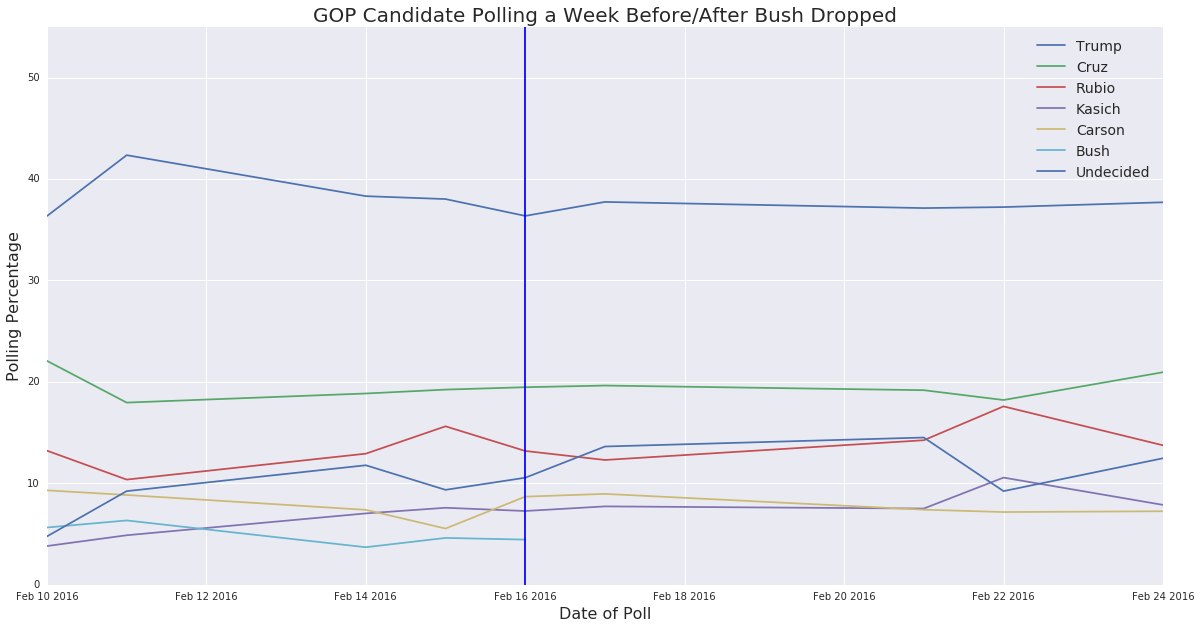

In [23]:
plt.figure(figsize=(20,10))

plt.plot(BushPolls1.Trump)
plt.plot(BushPolls1.Cruz)
plt.plot(BushPolls1.Rubio)
plt.plot(BushPolls1.Kasich)
plt.plot(BushPolls1.Carson)
plt.plot(BushPolls1.Bush)
plt.plot(BushPolls1.Undecided)

plt.axvline(candidates['date']['Bush'])

plt.title("GOP Candidate Polling a Week Before/After Bush Dropped", size=20)
plt.xlabel("Date of Poll", size=16)
plt.ylabel("Polling Percentage", size=16)

# y limits are a little greater than needed to display the legend without blocking out data
plt.ylim(0, 55)
plt.legend(fontsize=14)

## Write to File
Write the DataFrames PollingBeforeDrop and PollingAfterDrop to two separte files to be analyzed in 05-Analysis.ipynb

In [24]:
PollingBeforeDrop.to_csv('PollingBeforeDrop.csv')
PollingAfterDrop.to_csv('PollingAfterDrop.csv')